In [15]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from credentials import Credentials as cr
from prediction import ImmothepPrediction
import os
from split import Splitter

splitter = Splitter()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Création et import du jeu de données principal

In [200]:
valeurs2019 = pd.read_csv(cr.PATH+'2019.txt', sep='|', usecols=['Nature mutation', 'Code postal','Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere', 'Type local', 'Nombre de lots'], encoding='utf-8')

valeurs2019 = valeurs2019.dropna(subset = ['Type local', 'Nombre de lots', 'Nombre pieces principales', "Nature mutation"])

valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)] = valeurs2019['Surface terrain'][valeurs2019['Type local'].str.contains("Appartement", regex=True)].fillna(0) 

valeurs2019 = valeurs2019[['Code postal', 'Nombre pieces principales', 'Surface terrain', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot', 'Valeur fonciere']][valeurs2019['Type local'].str.contains("Appartement|Maison", regex=True)][valeurs2019['Nature mutation'].str.contains("Vente", regex=True)][valeurs2019['Nombre de lots']<6][valeurs2019['Nombre pieces principales']>0]

valeurs2019.to_csv(cr.CURATED_LOCAL_PATH + 'filtered2019.csv', index=False)

valeurs2019.head()

,Code postal,Nombre pieces principales,Surface terrain,Surface Carrez du 1er lot,Surface Carrez du 2eme lot,Surface Carrez du 3eme lot,Surface Carrez du 4eme lot,Surface Carrez du 5eme lot,Valeur fonciere
0,1000.0,1.0,0.0,"19,27",NaN,NaN,NaN,NaN,"37220,00"
1,1000.0,3.0,0.0,NaN,"61,51",NaN,NaN,NaN,"185100,00"
3,1160.0,4.0,940.0,NaN,NaN,NaN,NaN,NaN,"209000,00"
4,1370.0,5.0,490.0,NaN,NaN,NaN,NaN,NaN,"134900,00"
5,1340.0,4.0,708.0,NaN,NaN,NaN,NaN,NaN,"192000,00"


In [201]:
# Vérification du ratio de valeurs nulles en vue de nettoyer les données.

nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Valeur fonciere'])
nancount = valeurs2019["Valeur fonciere"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Valeur Foncière\'.")

nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Code postal'])
nancount = valeurs2019["Code postal"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Code postal\'.")


Il y a  3615  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  0  valeurs nulles dans la colonne 'Valeur Foncière'.
Il y a  54  valeurs nulles dans la colonne 'Code postal'.
Il y a  0  valeurs nulles dans la colonne 'Code postal'.


In [202]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935516 entries, 0 to 2535790
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Code postal                 935516 non-null  float64
 1   Nombre pieces principales   935516 non-null  float64
 2   Surface terrain             913663 non-null  float64
 3   Surface Carrez du 1er lot   187593 non-null  object 
 4   Surface Carrez du 2eme lot  50988 non-null   object 
 5   Surface Carrez du 3eme lot  4175 non-null    object 
 6   Surface Carrez du 4eme lot  842 non-null     object 
 7   Surface Carrez du 5eme lot  207 non-null     object 
 8   Valeur fonciere             935516 non-null  object 
dtypes: float64(3), object(6)
memory usage: 71.4+ MB


In [203]:
valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']] = valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].replace(',', '.', regex=True)

valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']]  = valeurs2019[['Valeur fonciere', 'Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot']].astype('float')

In [204]:
valeurs2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935516 entries, 0 to 2535790
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Code postal                 935516 non-null  float64
 1   Nombre pieces principales   935516 non-null  float64
 2   Surface terrain             913663 non-null  float64
 3   Surface Carrez du 1er lot   187593 non-null  float64
 4   Surface Carrez du 2eme lot  50988 non-null   float64
 5   Surface Carrez du 3eme lot  4175 non-null    float64
 6   Surface Carrez du 4eme lot  842 non-null     float64
 7   Surface Carrez du 5eme lot  207 non-null     float64
 8   Valeur fonciere             935516 non-null  float64
dtypes: float64(9)
memory usage: 71.4 MB


In [206]:
valeurs2019 = valeurs2019[valeurs2019['Valeur fonciere']>200]

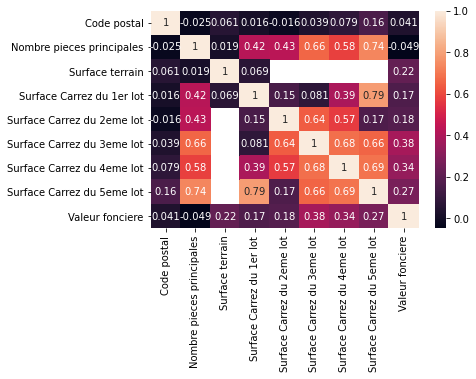

In [207]:
corrMatrix = valeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [208]:
nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")
valeurs2019 = valeurs2019.dropna(subset = ['Surface terrain'])

nancount = valeurs2019["Surface terrain"].isna()
print ("Il y a ", nancount.sum(), " valeurs nulles dans la colonne \'Surface Terrain\'.")

valeurs2019 = valeurs2019.fillna(0)

Il y a  21748  valeurs nulles dans la colonne 'Surface Terrain'.
Il y a  0  valeurs nulles dans la colonne 'Surface Terrain'.


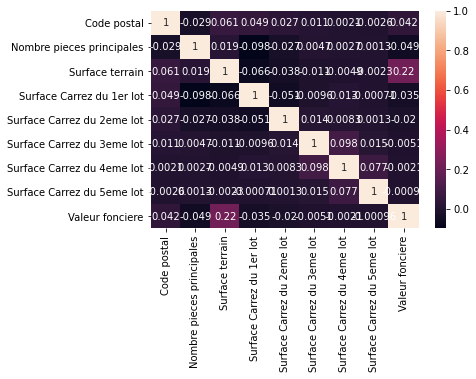

In [209]:
corrMatrix = valeurs2019.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

Test de la prédiction de la valeur foncière sur l'élémant d'index 5 de valeurs2019

In [113]:
predictor = ImmothepPrediction()

try:
    result = predictor.predict(valeurs2019, 5)
except : 
    print('Elément non trouvé.')

NOMBRE DE VALEURS NULLES :
 Code postal                   0
Nombre pieces principales     0
Surface terrain               0
Surface Carrez du 1er lot     0
Surface Carrez du 2eme lot    0
Surface Carrez du 3eme lot    0
Surface Carrez du 4eme lot    0
Surface Carrez du 5eme lot    0
Valeur fonciere               0
dtype: int64
*******************
y_train_encoded: [ 632  932 1700 ...  693 1120  308]
utils.multiclass.type_of_target(y_train):  continuous
utils.multiclass.type_of_target(y_train.astype('int')):  multiclass
utils.multiclass.type_of_target(y_train_encoded):  multiclass
*******************
Valeur foncière estimée :  [180000.]
Valeur foncière réelle :  192000.0
Précision du test :  0.0


Modification du modèle

In [210]:
modele, scaler, lab_enc = predictor.entrainementLR(valeurs2019)

result = predictor.predictionLR(valeurs2019[valeurs2019.index==693], modele, scaler, lab_enc)

NOMBRE DE VALEURS NULLES :
 Code postal                   0
Nombre pieces principales     0
Surface terrain               0
Surface Carrez du 1er lot     0
Surface Carrez du 2eme lot    0
Surface Carrez du 3eme lot    0
Surface Carrez du 4eme lot    0
Surface Carrez du 5eme lot    0
Valeur fonciere               0
dtype: int64
*******************
y_train_encoded: [763 513 835 ... 565 448 440]
utils.multiclass.type_of_target(y_train):  continuous
utils.multiclass.type_of_target(y_train.astype('int')):  multiclass
utils.multiclass.type_of_target(y_train_encoded):  multiclass
*******************
Valeur foncière estimée :  4097667.5
Valeur foncière réelle :  693    370000.0
Name: Valeur fonciere, dtype: float64


In [213]:
predictor.predictionLR(valeurs2019[valeurs2019.index==10], modele, scaler, lab_enc)

Valeur foncière estimée :  55000.0
Valeur foncière réelle :  10    37000.0
Name: Valeur fonciere, dtype: float64


array([55000.])

Modification du dataset

<AxesSubplot:>

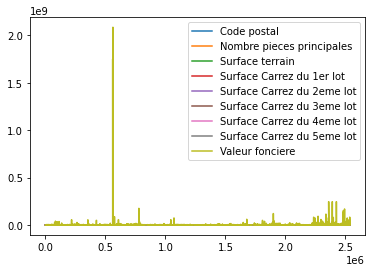

In [214]:
valeurs2019.plot.scatter("Surface terrain", "Valeur fonciere")